In [4]:
import pandas as pd
data=pd.read_csv('Gird-LDA.csv')
print(data)
print(data.shape)

      Unnamed: 0                                            Reviews  \
0              0  Okay, so I'm not a big video game buff, but wa...   
1              1  The premise of this movie has been tickling my...   
2              2  Jim Carrey is back to much the same role that ...   
3              3  I read several mixed reviews and several of th...   
4              4  Warning: Does contain spoilers.<br /><br />Ope...   
...          ...                                                ...   
2495        2495  I thought the whole movie played out beautiful...   
2496        2496  "Seed" is torture porn...no doubt about it. Bu...   
2497        2497  The title alone (along with the poster) is eno...   
2498        2498  This is one of the best animated family films ...   
2499        2499  I loved KOLCHAK: THE NIGHT STALKER since I saw...   

                                              processed  \
0     ['big', 'video', 'game', 'buff', 'game', 'hous...   
1     ['premise', 'movie', 't

In [5]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import contractions
import swifter

def tosentences(article):
    sentences=article.split(". ")
    sentences=[sentence.strip() for sentence in sentences]
    return sentences

In [6]:
def preprocess(sentences, min_word_length=2):
    preprocessed_sentences = []
    for sentence in sentences:
        soup = BeautifulSoup(sentence, 'html.parser')
        sentence = soup.get_text()
        sentence = contractions.fix(sentence)
        words = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
        words = [re.sub(r'\d+', '', word) for word in words]  
        words = [re.sub(r'\d', '', word) for word in words]   
        words = [re.sub(r'(.)\1+', r'\1\1', word) for word in words] 
        words = [re.sub(r'\{.*?\}', '', word) for word in words] 
        words = [re.sub(r'^[\'\s]*|[^\w\s\'-]', '', word) for word in words] 
        words = [re.sub(r'\.{3,}', '', word) for word in words]  
        words = [re.sub(r'\.{4,}', '', word) for word in words]  
        words = [re.sub(r'\.( +)', '.', word) for word in words] 
        words = [word for word in words if len(word) >= min_word_length and not word.isnumeric() and word not in string.punctuation]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        preprocessed_sentence = ' '.join(words)
        preprocessed_sentences.append(preprocessed_sentence)
    
    return preprocessed_sentences

In [7]:
def wordtokenize(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        tokenized_sentences.append(words)
    return tokenized_sentences

In [8]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import swifter
import pandas as pd

def compute_coherence(lda_model, tokenized_sentences, dictionary, corpus):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_sentences, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    return coherence_score

def train(row):
    print(row.name,end=' ')
    tokenized_sentences = [word_tokenize(sentence) for sentence in row['processed']]
    dictionary = corpora.Dictionary(tokenized_sentences)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_sentences]
    
    lda_model = models.LdaModel(
        corpus=corpus,
        num_topics=5,
        id2word=dictionary,
        passes=10,
        alpha=0.113333,
        eta=0.180268,
        decay=0.687962,
        offset=2.292440,
        random_state=23,
        minimum_probability=0.054791
    )
    
    coherence_score = compute_coherence(lda_model, tokenized_sentences, dictionary, corpus)
    
    sentence_topic_distributions = []
    for doc in corpus:
        sentence_topic_distribution = lda_model.get_document_topics(doc)
        sentence_topic_distributions.append(dict(sentence_topic_distribution))
        
    topic_words_list = []
    for idx, topic in lda_model.print_topics(-1):
        topic_words = [word.split('"')[1] for word in topic.split()[1:] if '"' in word]
        topic_words_list.append(topic_words)
    
    row['topic_words'] = topic_words_list
    row['sentence_topic_distributions'] = sentence_topic_distributions
    row['coherence_score'] = coherence_score
    return row

In [23]:
import ast
import swifter

def filter_topic_distribution(topic_distribution_list):
    theta = 0.1
    t1_list = []
    distribution_list = ast.literal_eval(topic_distribution_list)
    for distribution in distribution_list:
        filtered_distribution = [{k: v} for k, v in distribution.items() if v > theta]
        t1_list.extend(filtered_distribution)
    return t1_list

In [10]:
def get_dominant_topics(sentence_topic_distribution):
    dominant_topics = []
    for distribution in sentence_topic_distribution:
        dominant_topic = max(distribution, key=distribution.get)
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [11]:
def get_topic_words(row):
    index_values = row['ST']
    topic_words = row['topic_words']
    result = []
    for index in index_values:
        if 0 <= index < len(topic_words):
            result.append(topic_words[index])
        else:
            result.append(None) 
    return result

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from senticnet.senticnet import SenticNet
sid = SentimentIntensityAnalyzer()
sn = SenticNet()


def sentic(word):
     score=0
     if word in sn.data:
        sentiment_info = sn.concept(word)
        score = float(sentiment_info.get('polarity_value', 0))
     return score

def TEXTBLOB(word):  
    sentiment_score=TextBlob(word).sentiment.polarity
    return sentiment_score

def SA(word):
     sentiment_score = sid.polarity_scores(word)['compound'] 
     return sentiment_score
  
def match_and_calculate_sentiment(sentences, topic_words):
    sentiment_scores = []
    
    for sentence, words in zip(sentences, topic_words):
        sentiment_score=0
        for word in nltk.word_tokenize(sentence):
            if word in words:
                sentiment_score += (TEXTBLOB(word))
        sentiment_scores.append(sentiment_score)
        
    return sentiment_scores

In [13]:
def calculate_reaching_definition(df,r):
    definitions_generated = []
    definitions_killed = []
    
    for index, row in df.iterrows():
        row_definitions_generated = [set() for _ in range(len(row['processed']))]
        row_definitions_killed = [set() for _ in range(len(row['processed']))]
        
        for i, (sentence, topic_idx, sentiment_score) in enumerate(zip(row['processed'], row['ST'], row[r])):
            definition_generated = (topic_idx, sentiment_score)
            for j in range(i):
                if (row['ST'][j], row[r][j]) == definition_generated:
                    row_definitions_killed[i].add(j)
            row_definitions_generated[i].add(definition_generated)
            for j in range(i):
                if j not in row_definitions_killed[i]:
                    row_definitions_generated[i] |= row_definitions_generated[j]
        
        definitions_generated.append(row_definitions_generated)
        definitions_killed.append(row_definitions_killed)
    
    df['definitions_generated'] = definitions_generated
    df['definitions_killed'] = definitions_killed
    
    return df

In [14]:
def calculate_IN_OUT_sets(definitions_generated_col, definitions_killed_col):
    IN_sets = []
    OUT_sets = []
    for gen, killed in zip(definitions_generated_col, definitions_killed_col):
        OUT = [set() for _ in range(len(gen))]
        changed = True
        while changed:
            changed = False
            for i in range(len(gen)):
                IN = set().union(*[OUT[p] for p in range(len(gen)) if i not in killed[p]])
                new_OUT = gen[i].union(IN - killed[i])
                if new_OUT != OUT[i]:
                    OUT[i] = new_OUT
                    changed = True
        IN = [set().union(*[OUT[p] for p in range(len(gen)) if i in gen[p]]) for i in range(len(gen))]
        IN_sets.append(IN)
        OUT_sets.append(OUT)
    return IN_sets, OUT_sets

In [19]:
def generate_summary(sentences, S, sentiment_scores):
    summaries = []

    for doc_sentences, out, doc_sentiment_scores in zip(sentences, S, sentiment_scores):
        summary = ""
        added_indices = set()

        for out_set in out:
            for j in out_set:
                if isinstance(j, tuple):
                    j = j[0]
                j = int(j)  # Convert to integer
                if 0 <= j < len(doc_sentences) and j < len(doc_sentiment_scores):
                    if j not in added_indices:
                        summary += doc_sentences[j] + " "
                        added_indices.add(j)

        summaries.append(summary.strip())

    return summaries

In [16]:
from bs4 import BeautifulSoup
import contractions
import re
def preprocess_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = contractions.fix(text)
    text = re.sub(r'\\', '', text)
    return text

In [17]:
def classify_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'postive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [18]:
data['sentence']=data['Reviews'].swifter.apply(tosentences)
data['processed'] = data['sentence'].swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

C:\Users\akvnr\AppData\Local\Temp\ipykernel_16380\1479389325.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, 'html.parser')


In [20]:
Iter1=data

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

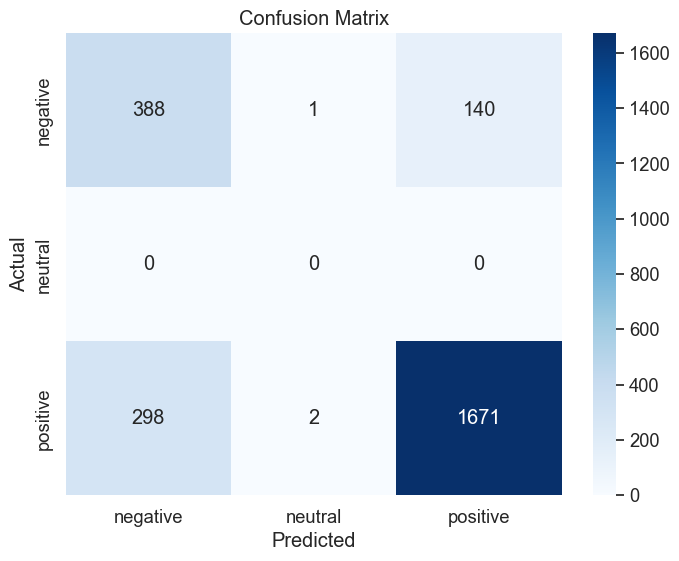

Accuracy: 0.8236
Precision: 0.8471329236782669
Recall: 0.8236
F1-score: 0.8318224518566396


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
Iter1['topic_words'] = Iter1['topic_words'].apply(ast.literal_eval)
Iter1['DTC'] = Iter1['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter1['ST']=Iter1['DTC'].swifter.apply(get_dominant_topics)
Iter1['ATW'] = Iter1.swifter.apply(get_topic_words, axis=1)
Iter1['sentiment_score'] = Iter1.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df1=calculate_reaching_definition(Iter1,'sentiment_score')
IN_sets1, OUT_sets1 = calculate_IN_OUT_sets(df1['definitions_generated'], df1['definitions_killed'])

S0 = [0] * len(OUT_sets1)
for i, out_set in enumerate(OUT_sets1):
    S0[i] = list(out_set)[-1] if out_set else None

summaries1= generate_summary(Iter1['sentence'], S0, Iter1['sentiment_score'])
summary_df1 = pd.DataFrame({'Summary': summaries1})

Iter1['TBLabel']=Iter1['Reviews'].swifter.apply( classify_sentiment)
summary_df1['TBLabel']=summary_df1['Summary'].swifter.apply( classify_sentiment)

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

actual = Iter1['TBLabel']
predicted = summary_df1['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy= accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, average='weighted')
recall = recall_score(actual, predicted, average='weighted')
f1 =f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [32]:
summary_df1['Summary'][1]

"That alone is the main reason to why these two guys get so well along, because they simply only have each other to turn to when comforting is needed The premise of this movie has been tickling my imagination for quite some time now What would you do if you were all alone in the world? What would you do if the entire world suddenly disappeared in front of your eyes? In fact, the last part is actually what happens to Dave and Andrew, two room-mates living in a run-down house in the middle of a freeway system We've all heard or read about it in some kind of con-text Andrew is a nervous wreck to say the least and Dave is considered being one of the biggest losers of society"

In [33]:
Iter1['Reviews'][0]

"Okay, so I'm not a big video game buff, but was the game House of the Dead really famous enough to make a movie from? Sure, they went as far as to actually put in quick video game clips throughout the movie, as though justifying any particular scene of violence, but there are dozens and dozens of games that look exactly the same, with the hand in the bottom on the screen, supposedly your own, holding whatever weapon and goo-ing all kinds of aliens or walking dead or snipers or whatever the case may be.<br /><br />It's an interesting premise in House of the Dead, with a lot of college kids (LOADED college kids, as it were, kids who are able to pay some fisherman something like $1,500 just for a ride after they miss their boat) trying to get out to this island for what is supposed to be the rave of the year. The first thing that comes to mind about House of the Dead after watching it is that it has become increasingly clear that modern horror movies have become nothing more than an exer

In [34]:
def avg(df, column_name):
    column = df[column_name]
    if len(column) == 0:
        return 0  
    total_score = sum(column)
    avg_score = total_score / len(column)
    return avg_score

In [36]:
avg_score =avg(Iter1,'coherence_score')
print(avg_score)

0.8529102227063727


In [49]:
from collections import Counter

def k_words(processed_documents, k=10):
    all_words = [word for sublist in processed_documents for doc in sublist for word in doc.split()]
    word_freq = Counter(all_words)
    top_words = [word for word, _ in word_freq.most_common(k)]
    return top_words

In [38]:
def evaluate_relevance(summary, topic_keywords):
    relevance_score = 0
    for keyword in topic_keywords:
        if keyword.lower() in summary.lower():
            relevance_score += 1
    normalized_relevance_score = relevance_score / len(topic_keywords)
    return normalized_relevance_score

def evaluate_summary(df_summary):
    
    relevance_scores = []
    for summary, topic_keywords in zip(df_summary['Summary'], df_summary['top']):
        relevance_score = evaluate_relevance(summary, topic_keywords)
        relevance_scores.append(relevance_score)
    df_summary['Relevance Score'] = relevance_scores
    
    return df_summary

In [40]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [41]:
def calculate_fluency_score(summary):
    tokens = word_tokenize(summary)
    tagged_tokens = pos_tag(tokens)
    correct_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS',
                    'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH',
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
    correct_count = sum(1 for _, tag in tagged_tokens if tag in correct_tags)
    fluency_score = correct_count / len(tokens)
    return fluency_score


In [51]:
summary_df1['top']=Iter1['topic_words'].swifter.apply(k_words)
summary_df1=evaluate_summary(summary_df1)
summary_df1['Fluency Score'] = summary_df1['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [52]:
fluency=avg(summary_df1,'Fluency Score')
relevance=avg(summary_df1,'Relevance Score')     
print('Fluency = '+str(fluency))
print('Relevance = '+str(relevance))

Fluency = 0.9308950276640225
Relevance = 0.6516


In [54]:
from rouge_score import rouge_scorer

def calculate_rouge(reference_summary, generated_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    
    rouge1_score = [scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure]
    rouge2_score = [scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure]
    rougeL_score = [scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure]
    
    return rouge1_score, rouge2_score, rougeL_score


In [55]:
PR = pd.read_csv('PageRank.csv')
PR=PR.iloc[:2500]

In [58]:
import numpy as np

avg_rouge_scores_list = []

for i in range(1, 2):
    print(i,end=' ')
    df = summary_df1 
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for index, row in df.iterrows():
        reference_summary = str(PR.loc[index, 'Summary'])  
        generated_summary = str(row['Summary']) 
        
        rouge1_score, rouge2_score, rougeL_score = calculate_rouge(reference_summary, generated_summary)
        
        rouge1_scores.append(rouge1_score)
        rouge2_scores.append(rouge2_score)
        rougeL_scores.append(rougeL_score)
    
    
    avg_rouge1_precision = np.mean([score[0] for score in rouge1_scores])
    avg_rouge1_recall = np.mean([score[1] for score in rouge1_scores])
    avg_rouge1_fmeasure = np.mean([score[2] for score in rouge1_scores])
    
    avg_rouge2_precision = np.mean([score[0] for score in rouge2_scores])
    avg_rouge2_recall = np.mean([score[1] for score in rouge2_scores])
    avg_rouge2_fmeasure = np.mean([score[2] for score in rouge2_scores])
    
    avg_rougeL_precision = np.mean([score[0] for score in rougeL_scores])
    avg_rougeL_recall = np.mean([score[1] for score in rougeL_scores])
    avg_rougeL_fmeasure = np.mean([score[2] for score in rougeL_scores])
    
    avg_rouge_scores_list.append({
        'df_name': df_name,
        'avg_rouge1_precision': avg_rouge1_precision,
        'avg_rouge1_recall': avg_rouge1_recall,
        'avg_rouge1_fmeasure': avg_rouge1_fmeasure,
        'avg_rouge2_precision': avg_rouge2_precision,
        'avg_rouge2_recall': avg_rouge2_recall,
        'avg_rouge2_fmeasure': avg_rouge2_fmeasure,
        'avg_rougeL_precision': avg_rougeL_precision,
        'avg_rougeL_recall': avg_rougeL_recall,
        'avg_rougeL_fmeasure': avg_rougeL_fmeasure
    })

for avg_rouge_scores in avg_rouge_scores_list:
    print("Average ROUGE-1 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge1_precision'],
                                                            avg_rouge_scores['avg_rouge1_recall'],
                                                            avg_rouge_scores['avg_rouge1_fmeasure']])
    print("Average ROUGE-2 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge2_precision'],
                                                            avg_rouge_scores['avg_rouge2_recall'],
                                                            avg_rouge_scores['avg_rouge2_fmeasure']])
    print("Average ROUGE-L Precision, Recall, F-measure:", [avg_rouge_scores['avg_rougeL_precision'],
                                                            avg_rouge_scores['avg_rougeL_recall'],
                                                            avg_rouge_scores['avg_rougeL_fmeasure']])
    print()


1 Average ROUGE-1 Precision, Recall, F-measure: [0.48123520888769217, 0.5407651592530756, 0.4913538521757153]
Average ROUGE-2 Precision, Recall, F-measure: [0.3061587631777938, 0.36547812095638915, 0.32249473814943375]
Average ROUGE-L Precision, Recall, F-measure: [0.32321119374377116, 0.3699360765968988, 0.33280439196185985]



In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  
    tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

In [60]:
summary_df1['Summary']=summary_df1['Summary'].apply(preprocess_text)

In [67]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = make_pipeline(TfidfVectorizer(), LinearSVC())
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.82014388 0.80672269 0.81032413]
Mean accuracy: 0.8123969012065259


In [81]:
def predict_sentiment(sentence):
    preprocessed_sentence = preprocess_text(sentence)
    return model.predict([preprocessed_sentence])[0]

In [69]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = make_pipeline(TfidfVectorizer(), LinearSVC())
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.8056 0.8096]
Mean accuracy: 0.8076


In [70]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.78177458 0.77430972 0.77791116]
Mean accuracy: 0.7779984895636911


In [71]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.776  0.7624]
Mean accuracy: 0.7692


In [73]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model1 = ('svm', LinearSVC())
model2 = ('nb', MultinomialNB())
model3 = ('lr', LogisticRegression())
model4 = ('rf', RandomForestClassifier())

ensemble_models = [model1, model2, model3, model4]

ensemble_classifier = VotingClassifier(estimators=ensemble_models, voting='hard')

pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.79856115 0.79111645 0.78871549]
Mean accuracy: 0.7927976946174153


In [74]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model1 = ('svm', LinearSVC())
model2 = ('nb', MultinomialNB())
model3 = ('lr', LogisticRegression())
model4 = ('rf', RandomForestClassifier())

ensemble_models = [model1, model2, model3, model4]

ensemble_classifier = VotingClassifier(estimators=ensemble_models, voting='hard')

pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores: [0.79856115 0.78751501 0.78751501]
Mean accuracy: 0.7911970543613128


In [76]:
from itertools import combinations

models = [
    ('svm', LinearSVC()),
    ('nb', MultinomialNB()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier())
]

best_score = 0
best_combination = None

for i in range(2, 4):
    for model_combination in combinations(models, i):
        model_combination_list = list(model_combination)
        ensemble_classifier = VotingClassifier(estimators=model_combination_list, voting='hard')
        pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)
        cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)     
        mean_accuracy = cv_scores.mean()
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_combination = model_combination_list

print("Best combination:", best_combination)
print("Best mean accuracy:", best_score)


Best combination: [('svm', LinearSVC()), ('rf', RandomForestClassifier())]
Best mean accuracy: 0.8167972224861167


In [80]:
from sklearn.pipeline import Pipeline


best_models = [
    ('svm', LinearSVC()),
    ('rf', RandomForestClassifier())
]


best_models_list = list(best_models)
ensemble_classifier = VotingClassifier(estimators=best_models_list, voting='hard')
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', ensemble_classifier)])
pipeline.fit(summary_df1['preprocessed_sentence'], summary_df1['TBLabel'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier',
                 VotingClassifier(estimators=[('svm', LinearSVC()),
                                              ('rf',
                                               RandomForestClassifier())]))])

In [86]:
new_data = [PR['Summary'][1] ]
predicted_label = pipeline.predict(new_data)[0]  
print("Predicted label for the new data:", predicted_label)

Predicted label for the new data: postive


In [87]:
PR['Summary'][1]

'<br /><br />One of the best parts of the film is the set  One of the best visual effects in the film is at the end where Andrew and Dave suddenly discover their powers in this environment - they have the abilities to wish everything away, so what if they can do it the other way around and make things appear?<br /><br />"Nothing" is a bright and well-lit movie, it really helps promoting the idea of them probably being dead (this is in fact one of their theories), but "Nothing" is a comedy and it slowly destroys its own theory  He talks about him and André Bijelic having been room-mates at a time and they both were in this extremely dull room with no hope of getting out, "Nothing" could very well be the screened version of the origin of the Cube story, and to that end, it\'s almost like one of the Cube prequels <br /><br />What can I say? I enjoyed "Nothing", it is a great movie and the different parts of the movie are extremely well-made with tons of intelligent ideas, still I feel the

In [90]:
import numpy as np

PR['Summary'] = PR['Summary'].fillna('')
predicted_labels = []
for summary in PR['Summary']:
    predicted_label = pipeline.predict([summary])[0]
    predicted_labels.append(predicted_label)

PR['Predicted_Label'] = predicted_labels

In [91]:
PR.head(2)

,Unnamed: 0,Summary,Predicted_Label
0,0,"Okay, so I'm not a big video game buff, but wa...",negative
1,1,<br /><br />One of the best parts of the film ...,postive


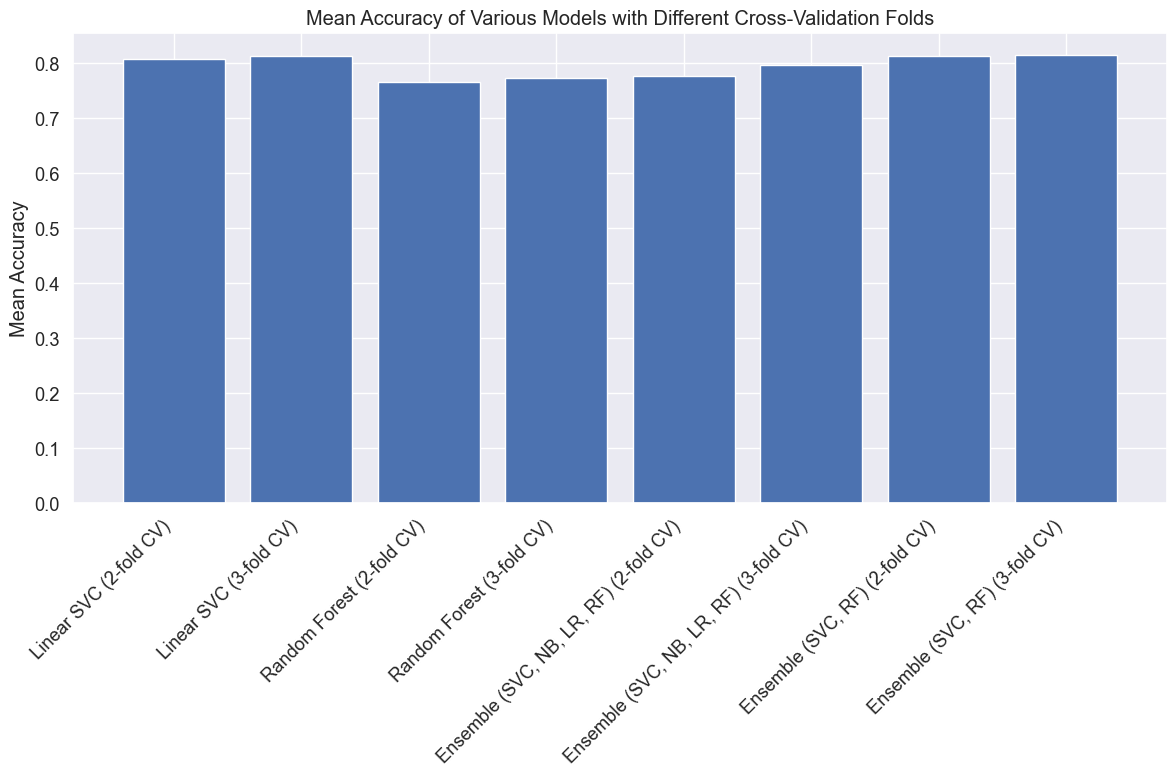

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

models = {
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Ensemble (SVC, NB, LR, RF)": VotingClassifier(
        estimators=[
            ('svc', LinearSVC()),
            ('nb', MultinomialNB()),
            ('lr', LogisticRegression()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    ),
    "Ensemble (SVC, RF)": VotingClassifier(
        estimators=[
            ('svc', LinearSVC()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    )
}

folds = [2, 3]

mean_accuracies = {}

for model_name, model in models.items():
    for fold in folds:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('classifier', model)
        ])
        cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, summary_df1['preprocessed_sentence'], summary_df1['TBLabel'], cv=cv)
        mean_accuracy = np.mean(cv_scores)
        mean_accuracies[(model_name, fold)] = mean_accuracy

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(models) * len(folds))
labels = [f"{model_name} ({fold}-fold CV)" for model_name, fold in mean_accuracies.keys()]
heights = mean_accuracies.values()
ax.bar(x, heights, tick_label=labels)
ax.set_ylabel('Mean Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Mean Accuracy of Various Models with Different Cross-Validation Folds')
plt.tight_layout()
plt.show()
